Original paper: https://arxiv.org/abs/1806.00035

# 0. Read real and generated images#

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib

In [2]:
CHANNEL_NUM = 3
PICTURE_SIZE = 36


In [3]:
class ParticleDataset():
    def __init__(self, file):
        self.data = np.load(file)
        self.image = self.data['Pictures'].reshape(-1, CHANNEL_NUM*PICTURE_SIZE*PICTURE_SIZE)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, i):
        return {
            "Pictures": self.image[i],
        }

In [4]:
real_data = ParticleDataset('real.npz')
vae_data = ParticleDataset('vae.npz')
gan_data = ParticleDataset('gan.npz')

Make sure that the values of real and generated data are of the same order - it is important for cooperative binarizing

In [5]:
print (np.min(real_data.image), np.max(real_data.image))
print (np.min(gan_data.image), np.max(gan_data.image))
print (np.min(vae_data.image), np.max(vae_data.image))

0.0 1.0
0.0 1.0
-0.060338274 1.0206423


# 1. Binarize# 

To understand how real and generated objects are close to each other, we need to choose a space of features in which we look these objects at

We go the easiest way and take pixels' values as features.

In [6]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import math
## function which map object to probability distribution ##

def bin_counts (real_data, generated_data, number_of_bins=25):
    # binirize real and generated data, plot histogram and found density function
    
    model = MiniBatchKMeans(n_clusters = number_of_bins)
    bin_data = model.fit_predict(np.vstack((real_data, generated_data)))
    real_dist, real_edges = np.histogram(bin_data[:len(real_data)], bins=number_of_bins, range = [0, number_of_bins], density=True)
    gen_dist, gen_edges = np.histogram(bin_data[len(real_data):], bins=number_of_bins, range=[0, number_of_bins], density=True)
    
    plt.figure(figsize = (10,5))
    plt.hist(real_dist, bins = number_of_bins, label = 'real data')
    plt.hist(gen_dist, bins = number_of_bins, label ='generated data')
    plt.title('Probability distribution')
    plt.legend()
    plt.show()
    return real_dist, gen_dist

Create $\alpha-$ and $\beta-$ vectors as in

$\hat{PRD}(Q,P) = \{(\alpha(\lambda), \beta(\lambda))| \lambda \in \Lambda \}$, where $\Lambda = \{\tan (\frac{i}{m+1} \frac{\pi}{2}) | i = 1, 2 ... m\}$

In [7]:
def count_alpha_beta (real_density, gen_density, num_angles = 1000):
    assert real_density.shape == gen_density.shape
    alpha_vec = []
    beta_vec = []
    angles = np.linspace(1e-6, np.pi/2 - 1e-6, num=num_angles)
    
    angles = np.tan(angles)
    
    for i in angles:
        a = zip(i*real_density, gen_density)
        b = zip(real_density, gen_density/i)
        alpha = np.sum(np.array([min(a_1, a_2) for a_1, a_2 in a]))
        beta = np.sum(np.array([min(b_1, b_2) for b_1, b_2 in b]))
        alpha_vec.append(alpha)
        beta_vec.append(beta)
        
    return alpha_vec, beta_vec

For stability, take the average of several repetitions

In [8]:
def count_prd(reals, gens, repeat_number = 10):
    vectors = []
    for i in range(repeat_number):
        vectors.append(count_alpha_beta(reals, gens))
    vectors = np.mean(np.array(vectors),axis=0)
    return vectors

## 2. Apply it##

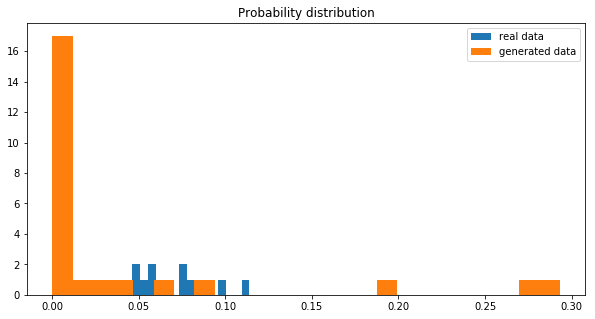

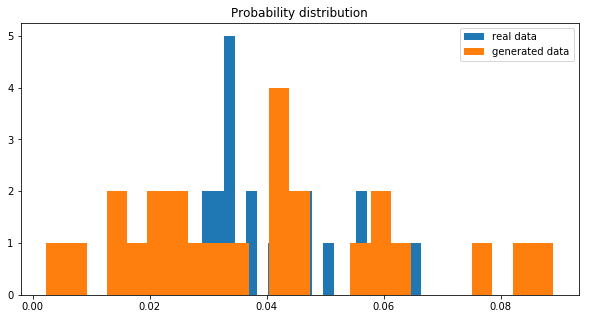

In [9]:
a, b = bin_counts(real_data.image, vae_data.image)
c, d = bin_counts(real_data.image, gan_data.image)

## 3. Make vectors for plot and plot ##

In [10]:
data_for_plots = count_prd(a, b)
data_for_plots2 = count_prd(c, d)

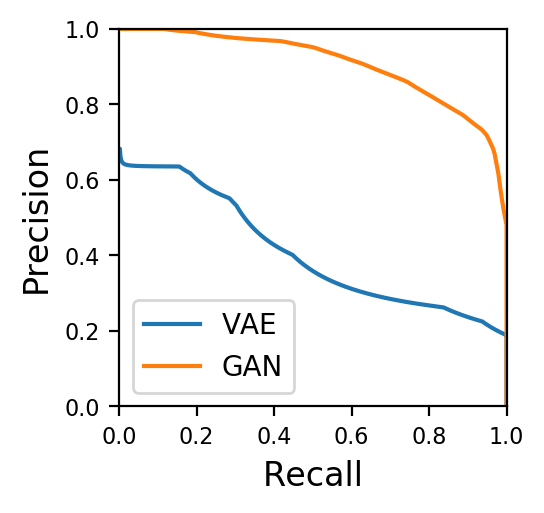

In [11]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=200)
fig.add_subplot(111).tick_params(axis='both', which='major', labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.plot(data_for_plots[0], data_for_plots[1], label = "VAE")
plt.plot(data_for_plots2[0], data_for_plots2[1], label = "GAN")
plt.legend()
plt.show()

**What curves were obtained for the first(VAE) and the second(GAN) models? What can we say about the advantages and disadvantages of each model?**

The represented curves show that, GAN outperforms heavily VAE. The main point, despite that fact, that I trained VAE on 100 epoch only and GAN passed 40k epochs (that means, that VAE isn't trained enough, but according to guidance in GAN notebook I trained it twice longer, that expected), is the fact, that in VAE generated faces aren't beeing checked, whether they are close to real ones or not, but in GAN it's implemented. But in defence of VAE I can say, that the comparison in time isn't suitable: 6 minutes vs approx. 2 hours - flawless victory (FATALITY) by VAE. 

## Bonus: about features' space##

It is possible to transfer the picture-> embedding, for example, using the 1st part of the Inception network as a feature extraxtor. This embedding can be used for bin counts also

In [12]:
# if you came here and still alive, the implementation of idea above will give you extra points =)
